# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
! pip install --upgrade pip
! pip install pandas
! pip install seaborn
! pip install matplotlib


In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
import os

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# EXPLORE AND CLEAN PORTFOLIO DATAFRAME

In [2]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
portfolio.shape

(10, 6)

In [2]:
portfolio_df = portfolio.copy()

* Create a new column called offer which assigns numbers 1 - 10 for each type of offer. This will be used as offer_id in the final table for readability.
* Extract each channel from the list of channels
* Create a new column for each channel 
* Input 0 if the offer was not sent using the channel, 1 if it is. 
* Drop channel columns
* Create a column with duration by hour.
* Reorganize all columns.
* Save dataframe to csv

In [3]:
portfolio_df['offer'] = portfolio.index + 1

In [4]:
def create_channel_dummy (channels, channel=""):
    if channel in channels:
        return 1
    else:
        return 0

portfolio_df['web'] = portfolio_df['channels'].apply(create_channel_dummy, channel = "web")
portfolio_df['email'] = portfolio_df['channels'].apply(create_channel_dummy, channel = "email")
portfolio_df['mobile'] = portfolio_df['channels'].apply(create_channel_dummy, channel = "mobile")
portfolio_df['social'] = portfolio_df['channels'].apply(create_channel_dummy, channel = "social")

In [5]:
portfolio_df = portfolio_df.drop('channels', axis = 1)

In [6]:
portfolio_df = portfolio_df[["id", "offer", "offer_type", "difficulty", "duration", "reward", "web", "email", "social", "mobile"]]

In [7]:
portfolio_df['duration_hr'] = portfolio_df['duration'] * 24

In [8]:
portfolio_df

,id,offer,offer_type,difficulty,duration,reward,web,email,social,mobile,duration_hr
0,ae264e3637204a6fb9bb56bc8210ddfd,1,bogo,10,7,10,0,1,1,1,168
1,4d5c57ea9a6940dd891ad53e9dbe8da0,2,bogo,10,5,10,1,1,1,1,120
2,3f207df678b143eea3cee63160fa8bed,3,informational,0,4,0,1,1,0,1,96
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,4,bogo,5,7,5,1,1,0,1,168
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,discount,20,10,5,1,1,0,0,240
5,2298d6c36e964ae4a3e7e9706d1fb8c2,6,discount,7,7,3,1,1,1,1,168
6,fafdcd668e3743c1bb461111dcafc2a4,7,discount,10,10,2,1,1,1,1,240
7,5a8bc65990b245e5a138643cd4eb9837,8,informational,0,3,0,0,1,1,1,72
8,f19421c1d4aa40978ebb69ca19b0e20d,9,bogo,5,5,5,1,1,1,1,120
9,2906b810c7d4411798c6938adc9daaa5,10,discount,10,7,2,1,1,0,1,168


In [11]:
# portfolio_df.to_csv('data/portfolio_df.csv', index = False)

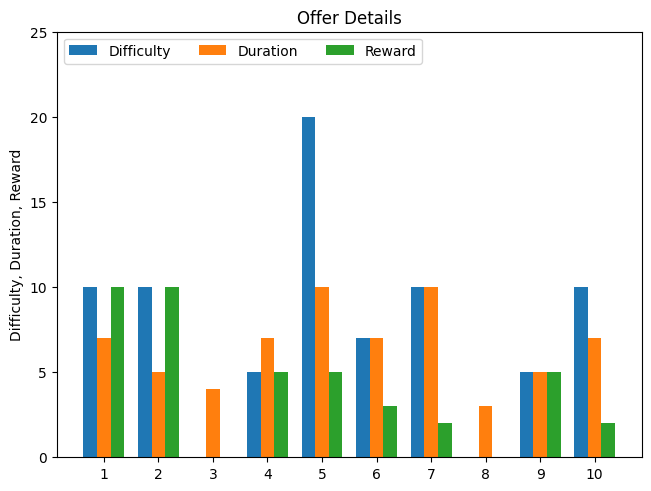

In [12]:
offers = tuple(list(portfolio_df.offer))
offer_details = {
    'Difficulty': list(portfolio['difficulty']),
    'Duration': list(portfolio['duration']),
    'Reward': list(portfolio['reward']),
}
x_labels = offers

x = np.arange(len(offers))  
width = 0.25  
multiplier = 0

fig, ax = plt.subplots(constrained_layout=True)

for attribute, measurement in offer_details.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1
    

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Difficulty, Duration, Reward')
ax.set_title('Offer Details')
ax.set_xticks(x + width)
ax.set_xticklabels(x_labels)
ax.legend(loc='upper left', ncol=3)
ax.set_ylim(0, 25)

plt.show()

# plt.savefig(os.path.join('photos/diff_duration_reward.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures

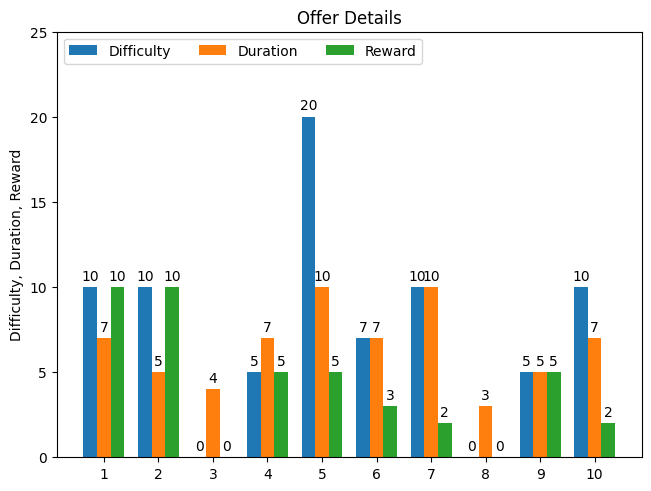

In [13]:
offers = tuple(list(portfolio_df.offer))
offer_details = {
    'Difficulty': list(portfolio['difficulty']),
    'Duration': list(portfolio['duration']),
    'Reward': list(portfolio['reward']),
}
x_labels = offers

x = np.arange(len(offers))  
width = 0.25
multiplier = 0

fig, ax = plt.subplots(constrained_layout=True)

for attribute, measurement in offer_details.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1
    
    # Add value annotations
    for i, rect in enumerate(rects):
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Difficulty, Duration, Reward')
ax.set_title('Offer Details')
ax.set_xticks(x + width)
ax.set_xticklabels(x_labels)
ax.legend(loc='upper left', ncol=3)
ax.set_ylim(0, 25)

plt.show()


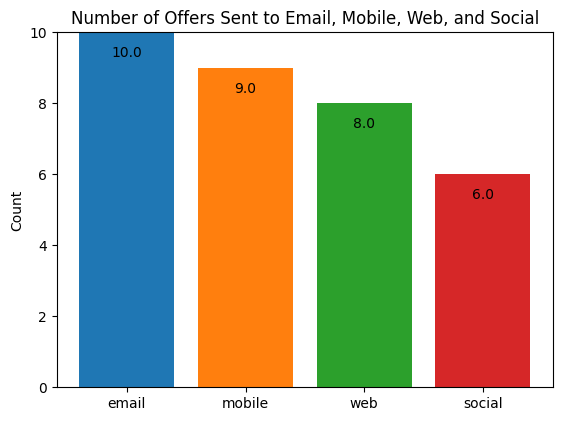

In [14]:
# create sample data
data = {
    'email': list(portfolio_df['email']),
    'mobile': list(portfolio_df['mobile']),
    'web': list(portfolio_df['web']),
    'social': list(portfolio_df['social'])
}

df = pd.DataFrame(data)


value_counts = df.apply(pd.Series.value_counts)

x_labels = value_counts.columns
x = np.arange(len(x_labels))

fig, ax = plt.subplots()
rects = ax.bar(x, value_counts.loc[1], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

for i, rect in enumerate(rects):
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, -20),  
                textcoords="offset points",
                ha='center', va='bottom')


ax.set_ylabel('Count')
ax.set_title('Number of Offers Sent to Email, Mobile, Web, and Social')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_ylim(0, len(df))

plt.subplots_adjust(top=0.85)

plt.show()

# plt.savefig(os.path.join('photos/offer_channels.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures

# Exploration and Cleaning of Profile Dataframe

In [15]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [16]:
profile.shape

(17000, 5)

In [17]:
len(profile.id.unique())

17000

In [18]:
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [19]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


* Remove NA values.
* Remove ages that are equal to 118.
* Find the membership duration in days using the difference between the maximum 'became member on' date and the actual 'became member on' date
* Rearrange the columns.
* Save the new table to csv


In [9]:
profile_df = profile.dropna()

In [10]:
profile_df['became_member_on'] = pd.to_datetime(profile_df['became_member_on'].astype(str), format='%Y%m%d')

/tmp/ipykernel_318/155769446.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile_df['became_member_on'] = pd.to_datetime(profile_df['became_member_on'].astype(str), format='%Y%m%d')


In [11]:
print(min(profile_df['became_member_on']))
print(max(profile_df['became_member_on']))

2013-07-29 00:00:00
2018-07-26 00:00:00


In [12]:
profile_df['membership_duration'] = round((max(profile_df['became_member_on']) - profile_df["became_member_on"]).dt.days) 

/tmp/ipykernel_318/659372463.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile_df['membership_duration'] = round((max(profile_df['became_member_on']) - profile_df["became_member_on"]).dt.days)


In [13]:
profile_df = profile_df[["id", "age", "gender", "income", "became_member_on", "membership_duration"]]

In [14]:
profile_df.head()

,id,age,gender,income,became_member_on,membership_duration
1,0610b486422d4921ae7d2bf64640c50b,55,F,112000.0,2017-07-15,376
3,78afa995795e4d85b5d9ceeca43f5fef,75,F,100000.0,2017-05-09,443
5,e2127556f4f64592b11af22de27a7932,68,M,70000.0,2018-04-26,91
8,389bc3fa690240e798340f5a15918d5c,65,M,53000.0,2018-02-09,167
12,2eeac8d8feae4a8cad5a6af0499a211d,58,M,51000.0,2017-11-11,257


In [26]:
# profile_df.to_csv('profile_df.csv', index = False)

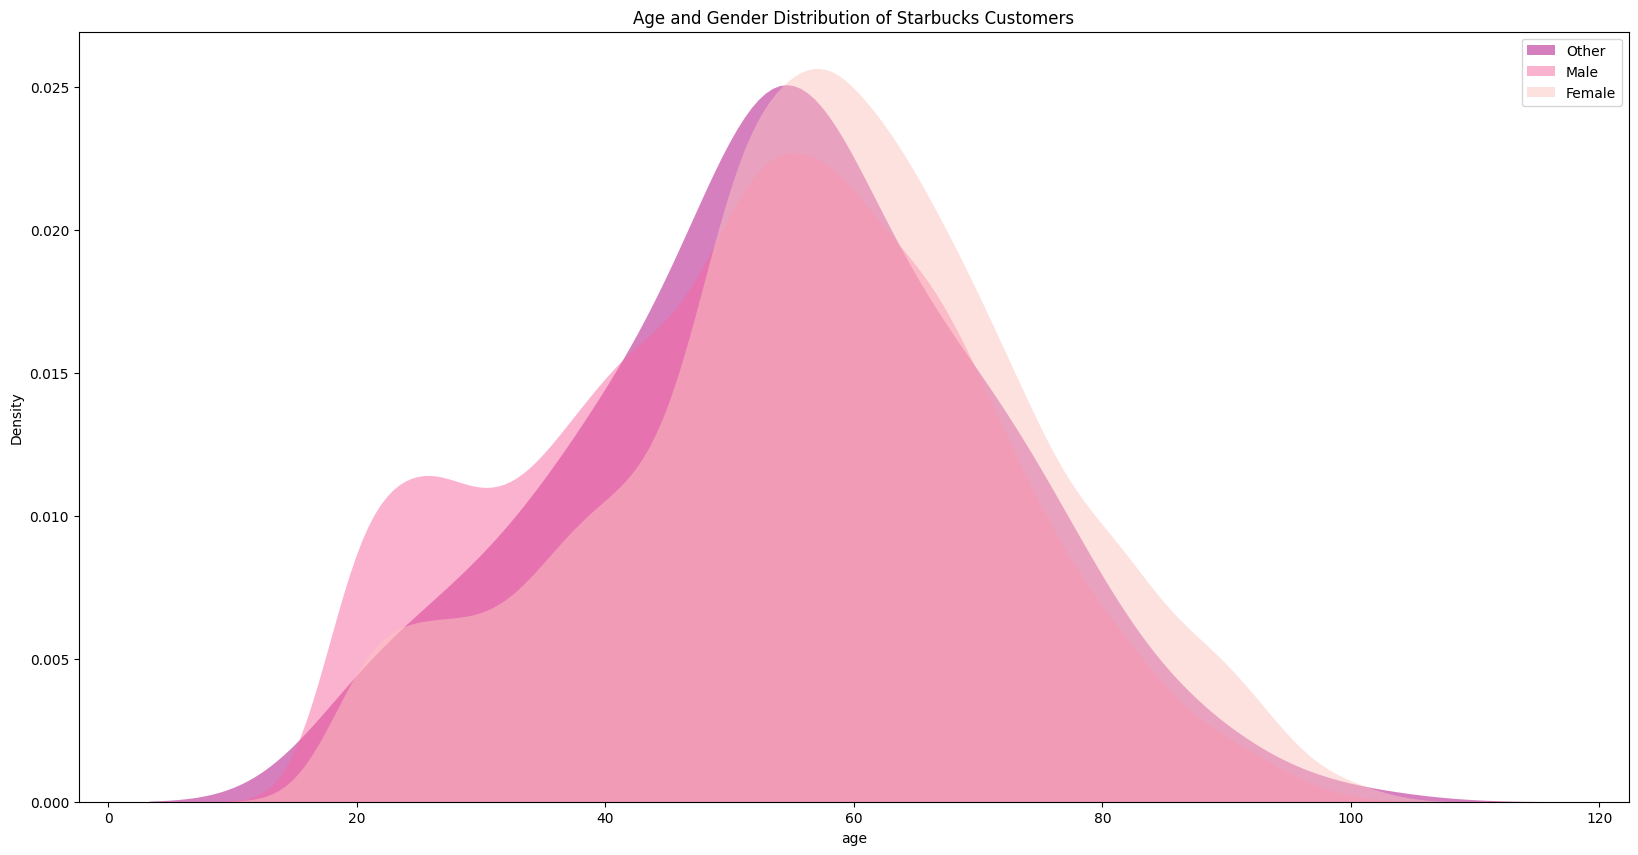

In [27]:
plt.figure(figsize=(20,10))
sns.kdeplot(
    data=profile_df, 
    x="age", 
    hue="gender",
    fill=True, 
    common_norm=False, 
    palette="RdPu",
    alpha=.5, 
    linewidth=0,
)
plt.legend(labels=['Other', 'Male', 'Female'])
plt.title('Age and Gender Distribution of Starbucks Customers')
plt.show()

# plt.savefig(os.path.join('photos/age_gender.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures

<Axes: title={'center': 'Gender of Starbucks Customers'}, ylabel='gender'>

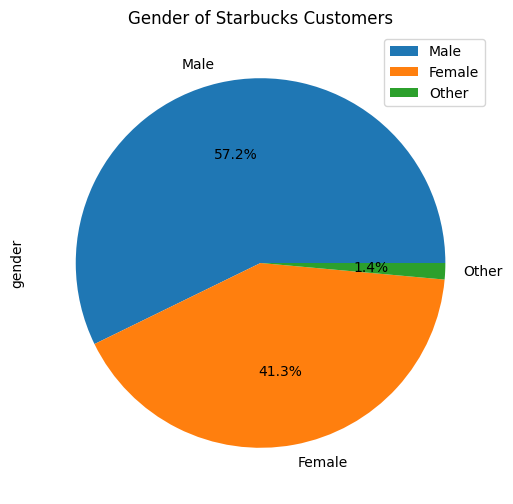

In [28]:
profile_df['gender'].value_counts().plot.pie(legend = True, 
                                             labels = ['Male', 'Female', 'Other'], 
                                             figsize=(11, 6),
                                             title = 'Gender of Starbucks Customers',
                                             autopct='%1.1f%%'
                                            )

# plt.savefig(os.path.join('photos/gender.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures

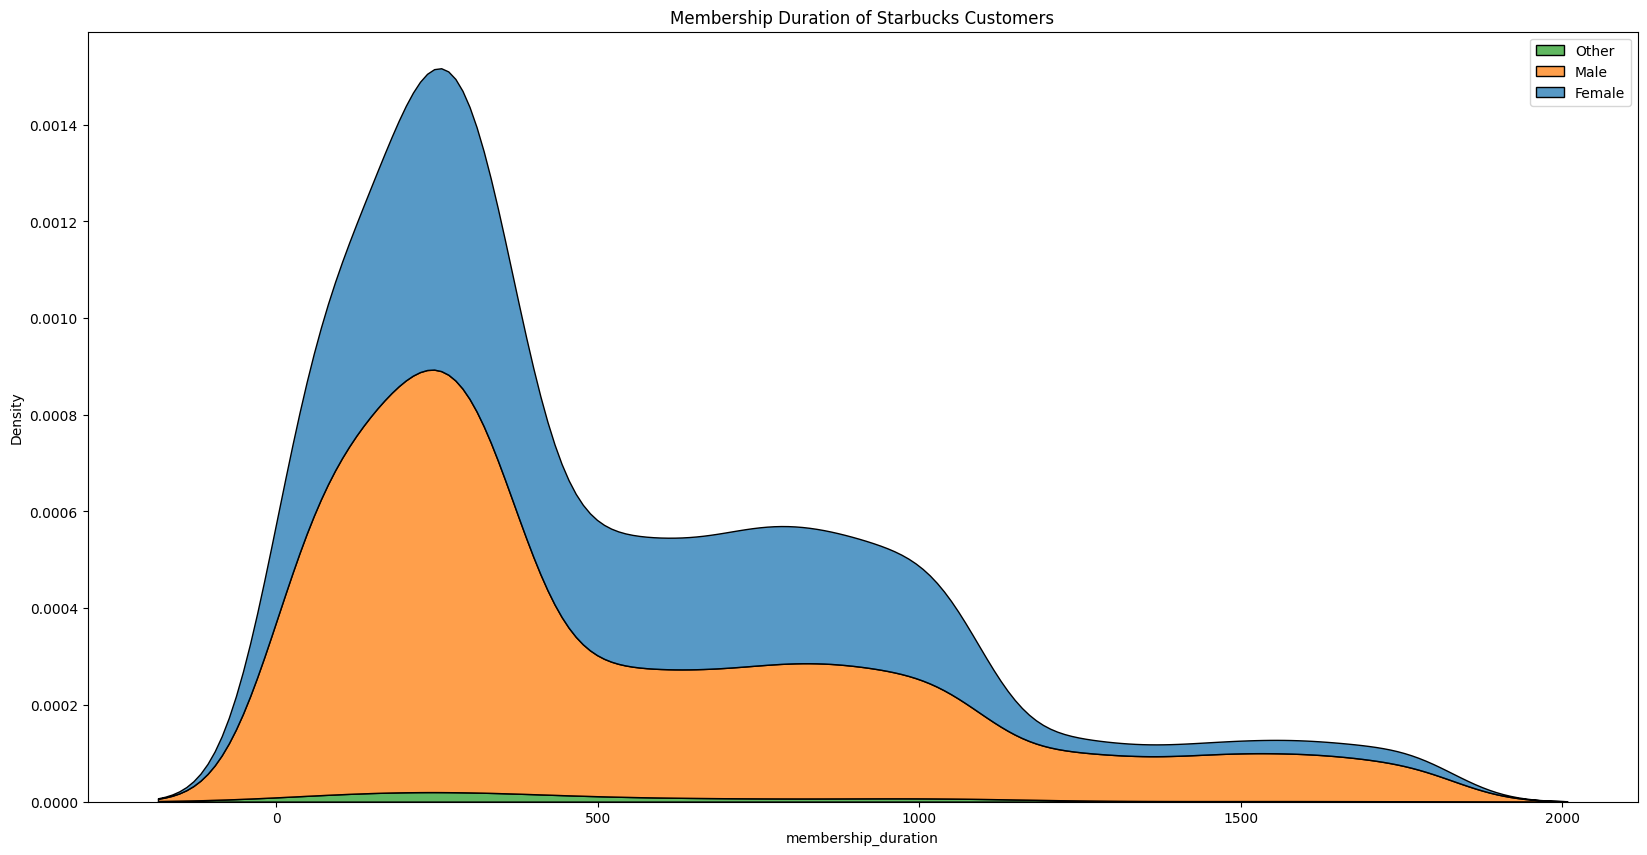

In [29]:
plt.figure(figsize=(20,10))
sns.kdeplot(data=profile_df, 
            x="membership_duration", 
            hue="gender", 
            multiple="stack")
plt.legend(labels = ['Other', 'Male', 'Female'])
plt.title('Membership Duration of Starbucks Customers')
plt.show()

# plt.savefig(os.path.join('photos/membership_duration.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures

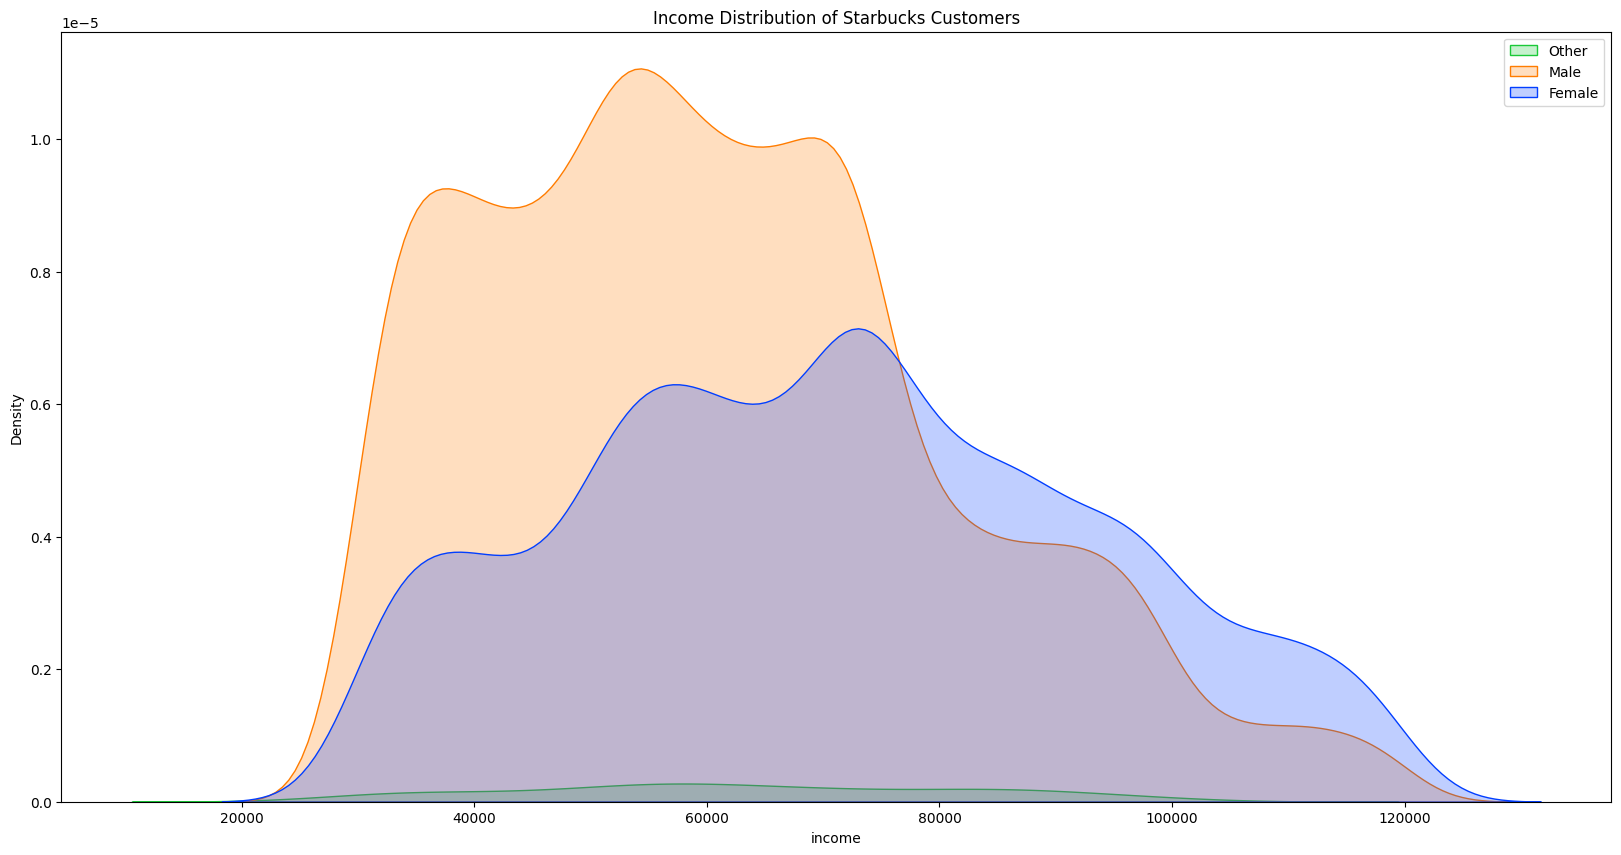

In [30]:
plt.figure(figsize=(20,10))
sns.kdeplot(
    data=profile_df, 
    x="income", 
    hue="gender",
    fill = True,
    palette="bright"
)
plt.legend(labels=['Other', 'Male', 'Female'])
plt.title('Income Distribution of Starbucks Customers')
plt.show()

# plt.savefig(os.path.join('photos/income_distribution.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures

# Transcript Dataframe

In [15]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [16]:
transcript.shape

(306534, 4)

In [17]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

* Split transaction into 4 dataframes: transaction_df, offer_received_df, offer_viewed, offer_completed
* Extract the value elements from the dictionary and create a new column for each.

## Event = Transaction

In [18]:
transcript[transcript.event == 'transaction'].head()

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0


In [19]:
offer_df = transcript.copy()

In [20]:
transaction_df = transcript[transcript.event == 'transaction']
transaction_df.shape

(138953, 4)

In [21]:
transaction_df.head()

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0


In [22]:
transaction_df['amount_spent'] = transaction_df['value'].apply(lambda x: x['amount'])

/tmp/ipykernel_318/2002219955.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transaction_df['amount_spent'] = transaction_df['value'].apply(lambda x: x['amount'])


In [23]:
transaction_df.head()

,person,event,value,time,amount_spent
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0,34.56
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0,18.97


In [24]:
transaction_df = transaction_df.drop('value', axis = 1)

In [25]:
transaction_df.head()

,person,event,time,amount_spent
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,34.56
12659,54890f68699049c2a04d415abc25e717,transaction,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,18.97


In [26]:
transaction_df.describe()

,time,amount_spent
count,138953.000000,138953.000000
mean,381.584334,12.777356
std,201.697230,30.250529
min,0.000000,0.050000
25%,210.000000,2.780000
50%,402.000000,8.890000
75%,552.000000,18.070000
max,714.000000,1062.280000


In [27]:
# transaction_df.to_csv('transaction.csv', index = False)

## Offer Received

In [28]:
transcript[transcript.event == 'offer received'].head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [29]:
offer_received_df = transcript[transcript.event == 'offer received']
offer_received_df.shape

(76277, 4)

In [30]:
offer_received_df['offer_id'] = offer_received_df['value'].apply(lambda x: x['offer id'])

/tmp/ipykernel_318/606598163.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offer_received_df['offer_id'] = offer_received_df['value'].apply(lambda x: x['offer id'])


In [31]:
offer_received_df = offer_received_df.drop('value', axis = 1)

In [32]:
offer_received_df.head()

,person,event,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0


## Offer Viewed

In [33]:
transcript[transcript.event == 'offer viewed'].head()

,person,event,value,time
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
12652,102e9454054946fda62242d2e176fdce,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0


In [34]:
offer_viewed_df = transcript[transcript.event == 'offer viewed']
offer_viewed_df.shape

(57725, 4)

In [35]:
offer_viewed_df['offer'] = offer_viewed_df['value'].apply(lambda x: x['offer id'])

/tmp/ipykernel_318/2444248740.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offer_viewed_df['offer'] = offer_viewed_df['value'].apply(lambda x: x['offer id'])


In [36]:
offer_viewed_df = offer_viewed_df.drop('value', axis = 1)

In [37]:
offer_viewed_df.head()

,person,event,time,offer
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,0,f19421c1d4aa40978ebb69ca19b0e20d
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,0,5a8bc65990b245e5a138643cd4eb9837
12652,102e9454054946fda62242d2e176fdce,offer viewed,0,4d5c57ea9a6940dd891ad53e9dbe8da0
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,0,ae264e3637204a6fb9bb56bc8210ddfd
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,0,5a8bc65990b245e5a138643cd4eb9837


In [38]:
offer_viewed_df.shape

(57725, 4)

In [39]:
# offer_viewed_df.to_csv('offer_viewed.csv', index = False)

## Offer Completed

In [40]:
transcript[transcript.event == 'offer completed'].head()

,person,event,value,time
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0


In [41]:
offer_completed_df = transcript[transcript.event == 'offer completed']
offer_completed_df.shape

(33579, 4)

In [42]:
offer_completed_df['offer_completed_id'] = offer_completed_df['value'].apply(lambda x: x['offer_id'])

/tmp/ipykernel_318/3662396521.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offer_completed_df['offer_completed_id'] = offer_completed_df['value'].apply(lambda x: x['offer_id'])


In [43]:
offer_completed_df['offer_completed_reward'] = offer_completed_df['value'].apply(lambda x: x['reward'])

/tmp/ipykernel_318/4197154511.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offer_completed_df['offer_completed_reward'] = offer_completed_df['value'].apply(lambda x: x['reward'])


In [44]:
offer_completed_df = offer_completed_df.drop('value', axis = 1)

In [45]:
# offer_completed_df.to_csv('offer_completed.csv', index = False)

In [46]:
offer_completed_df.head()

,person,event,time,offer_completed_id,offer_completed_reward
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,2906b810c7d4411798c6938adc9daaa5,2
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,0,fafdcd668e3743c1bb461111dcafc2a4,2
12679,629fc02d56414d91bca360decdfa9288,offer completed,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5
12692,676506bad68e4161b9bbaffeb039626b,offer completed,0,ae264e3637204a6fb9bb56bc8210ddfd,10
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,0,4d5c57ea9a6940dd891ad53e9dbe8da0,10


* Inner join offer_received_df with portfolio_df and create a new dataframe called offer_df and rename columns
* Left join offer_df with offer_viewed_df and rename columns
* Left join offer_df with offer_completed_df and rename columns.
* Left join offer_df with trransaction_df and rename columns.
* Inner join offer_df with profile_df.
* Rearrange columns
* Change the values of the transaction, received, viewed, and completed columns to Booleans.
* Fill na values in offer_completed_reward, amount_spent, transaction_time, time_completed, time_viewed with 0.

In [47]:
offer_df = pd.merge(
    offer_received_df,
    portfolio_df,
    how="inner",
    left_on="offer_id",
    right_on="id",
    copy = False,
    sort=True,
)

In [48]:
offer_df = offer_df.drop('id', axis = 1)

In [49]:
offer_df = offer_df.rename({'event':'received', 'difficulty': 'minimum_amount_required', 'time': 'time_received'}, axis = 1)

In [50]:
offer_df = offer_df[['person', 'offer_id', 'received', 'offer', 'offer_type', 'time_received', 'minimum_amount_required', 'duration','reward', 'web', 'email', 'social', 'mobile']]

In [51]:
offer_df = pd.merge(
    offer_df,
    offer_viewed_df,
    how="left",
    left_on=["person", "offer_id"],
    right_on=["person", "offer"],
    copy = False,
    sort=True,
)

In [52]:
offer_df = offer_df.rename({'event': 'viewed', 'time': 'time_viewed'}, axis = 1)

In [53]:
offer_df['viewed'].isna().value_counts()

False    79329
True     15992
Name: viewed, dtype: int64

In [54]:
offer_df['received'].isna().value_counts()

False    95321
Name: received, dtype: int64

In [55]:
offer_df = pd.merge(
    offer_df,
    offer_completed_df,
    how="left",
    left_on=["person", "offer_id"],
    right_on=["person", "offer_completed_id"],
    copy = False,
    sort=True,
)

In [56]:
offer_df = offer_df.rename({'event': 'completed', 'time': 'time_completed'}, axis = 1)

In [57]:
offer_df = pd.merge(
    offer_df,
    transaction_df,
    how="left",
    on="person",
    copy = False,
    sort=True,
)

In [58]:
offer_df["event"].isna().value_counts()

False    1032922
True        2364
Name: event, dtype: int64

In [59]:
offer_df = offer_df.drop(["offer_id", "offer_y", "offer_completed_id"], axis = 1) 

In [60]:
offer_df = offer_df.rename({"offer_x": "offer_id", "event": "transaction", "time": "transaction_time"}, axis = 1)

In [61]:
offer_df.head(2)

,person,received,offer_id,offer_type,time_received,minimum_amount_required,duration,reward,web,email,social,mobile,viewed,time_viewed,completed,time_completed,offer_completed_reward,transaction,transaction_time,amount_spent
0,0009655768c64bdeb2e877511632db8f,offer received,10,discount,576,10,7,2,1,1,0,1,NaN,NaN,offer completed,576.0,2.0,transaction,228.0,22.16
1,0009655768c64bdeb2e877511632db8f,offer received,10,discount,576,10,7,2,1,1,0,1,NaN,NaN,offer completed,576.0,2.0,transaction,414.0,8.57


In [62]:
offer_df = pd.merge(
    offer_df,
    profile_df,
    how="inner",
    left_on="person",
    right_on="id",
    copy = False,
    sort=True,
)

In [63]:
offer_df.head()

,person,received,offer_id,offer_type,time_received,minimum_amount_required,duration,reward,web,email,...,offer_completed_reward,transaction,transaction_time,amount_spent,id,age,gender,income,became_member_on,membership_duration
0,0009655768c64bdeb2e877511632db8f,offer received,10,discount,576,10,7,2,1,1,...,2.0,transaction,228.0,22.16,0009655768c64bdeb2e877511632db8f,33,M,72000.0,2017-04-21,461
1,0009655768c64bdeb2e877511632db8f,offer received,10,discount,576,10,7,2,1,1,...,2.0,transaction,414.0,8.57,0009655768c64bdeb2e877511632db8f,33,M,72000.0,2017-04-21,461
2,0009655768c64bdeb2e877511632db8f,offer received,10,discount,576,10,7,2,1,1,...,2.0,transaction,528.0,14.11,0009655768c64bdeb2e877511632db8f,33,M,72000.0,2017-04-21,461
3,0009655768c64bdeb2e877511632db8f,offer received,10,discount,576,10,7,2,1,1,...,2.0,transaction,552.0,13.56,0009655768c64bdeb2e877511632db8f,33,M,72000.0,2017-04-21,461
4,0009655768c64bdeb2e877511632db8f,offer received,10,discount,576,10,7,2,1,1,...,2.0,transaction,576.0,10.27,0009655768c64bdeb2e877511632db8f,33,M,72000.0,2017-04-21,461


In [64]:
offer_df = offer_df.drop("id", axis = 1)

In [65]:
offer_df = offer_df[["person", "age", "gender", "income", "became_member_on", "membership_duration", "offer_id", "offer_type", "minimum_amount_required", "duration", "reward", "web", "email", "social", "mobile", "transaction", "received", "viewed", "completed", "time_received", "time_viewed", "time_completed", "transaction_time", "amount_spent", "offer_completed_reward" ]]

In [66]:
offer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941143 entries, 0 to 941142
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   person                   941143 non-null  object        
 1   age                      941143 non-null  int64         
 2   gender                   941143 non-null  object        
 3   income                   941143 non-null  float64       
 4   became_member_on         941143 non-null  datetime64[ns]
 5   membership_duration      941143 non-null  int64         
 6   offer_id                 941143 non-null  int64         
 7   offer_type               941143 non-null  object        
 8   minimum_amount_required  941143 non-null  int64         
 9   duration                 941143 non-null  int64         
 10  reward                   941143 non-null  int64         
 11  web                      941143 non-null  int64         
 12  email           

In [67]:
offer_df['transaction'] = offer_df['transaction'].fillna(0).replace(to_replace="transaction", value=1)

In [68]:
offer_df['received'] = offer_df['received'].fillna(0).replace(to_replace="offer received", value=1)

In [69]:
offer_df['viewed'] = offer_df['viewed'].fillna(0).replace(to_replace="offer viewed", value=1)

In [70]:
offer_df['completed'] = offer_df['completed'].fillna(0).replace(to_replace="offer completed", value=1)

In [71]:
offer_df["offer_completed_reward"] = offer_df["offer_completed_reward"].fillna(0)

In [72]:
offer_df["amount_spent"] = offer_df["amount_spent"].fillna(0)

In [73]:
offer_df["transaction_time"] = offer_df["transaction_time"].fillna(0) 

In [74]:
offer_df["time_completed"] = offer_df["time_completed"].fillna(0) 

In [75]:
offer_df["time_viewed"] = offer_df["time_viewed"].fillna(0) 

In [76]:
offer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941143 entries, 0 to 941142
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   person                   941143 non-null  object        
 1   age                      941143 non-null  int64         
 2   gender                   941143 non-null  object        
 3   income                   941143 non-null  float64       
 4   became_member_on         941143 non-null  datetime64[ns]
 5   membership_duration      941143 non-null  int64         
 6   offer_id                 941143 non-null  int64         
 7   offer_type               941143 non-null  object        
 8   minimum_amount_required  941143 non-null  int64         
 9   duration                 941143 non-null  int64         
 10  reward                   941143 non-null  int64         
 11  web                      941143 non-null  int64         
 12  email           

In [77]:
# offer_df.to_csv('complete_df.csv', index = False)

In [78]:
offer_df.head()

,person,age,gender,income,became_member_on,membership_duration,offer_id,offer_type,minimum_amount_required,duration,...,transaction,received,viewed,completed,time_received,time_viewed,time_completed,transaction_time,amount_spent,offer_completed_reward
0,0009655768c64bdeb2e877511632db8f,33,M,72000.0,2017-04-21,461,10,discount,10,7,...,1,1,0,1,576,0.0,576.0,228.0,22.16,2.0
1,0009655768c64bdeb2e877511632db8f,33,M,72000.0,2017-04-21,461,10,discount,10,7,...,1,1,0,1,576,0.0,576.0,414.0,8.57,2.0
2,0009655768c64bdeb2e877511632db8f,33,M,72000.0,2017-04-21,461,10,discount,10,7,...,1,1,0,1,576,0.0,576.0,528.0,14.11,2.0
3,0009655768c64bdeb2e877511632db8f,33,M,72000.0,2017-04-21,461,10,discount,10,7,...,1,1,0,1,576,0.0,576.0,552.0,13.56,2.0
4,0009655768c64bdeb2e877511632db8f,33,M,72000.0,2017-04-21,461,10,discount,10,7,...,1,1,0,1,576,0.0,576.0,576.0,10.27,2.0


* Create a new df with only transactions wherein the offer had been viewed.

In [79]:
viewed_and_completed_df = offer_df.copy()

In [80]:
viewed_and_completed_df = offer_df[offer_df['viewed'] != 0]

In [81]:
viewed_and_completed_df.head()

,person,age,gender,income,became_member_on,membership_duration,offer_id,offer_type,minimum_amount_required,duration,...,transaction,received,viewed,completed,time_received,time_viewed,time_completed,transaction_time,amount_spent,offer_completed_reward
8,0009655768c64bdeb2e877511632db8f,33,M,72000.0,2017-04-21,461,3,informational,0,4,...,1,1,1,0,336,372.0,0.0,228.0,22.16,0.0
9,0009655768c64bdeb2e877511632db8f,33,M,72000.0,2017-04-21,461,3,informational,0,4,...,1,1,1,0,336,372.0,0.0,414.0,8.57,0.0
10,0009655768c64bdeb2e877511632db8f,33,M,72000.0,2017-04-21,461,3,informational,0,4,...,1,1,1,0,336,372.0,0.0,528.0,14.11,0.0
11,0009655768c64bdeb2e877511632db8f,33,M,72000.0,2017-04-21,461,3,informational,0,4,...,1,1,1,0,336,372.0,0.0,552.0,13.56,0.0
12,0009655768c64bdeb2e877511632db8f,33,M,72000.0,2017-04-21,461,3,informational,0,4,...,1,1,1,0,336,372.0,0.0,576.0,10.27,0.0


In [82]:
# viewed_and_completed_df.to_csv('viewed_completed.csv', index = False)